In [1]:
import os, sys

In [2]:
%pwd

u'/home/ubuntu/courses/my_nbs'

In [3]:
current_dir = os.getcwd()

In [5]:
LESSON_HOME_DIR = current_dir

In [6]:
DATA_HOME_DIR = current_dir+'/data/kaggle_dogs_cats'

In [7]:
sys.path[0]

''

In [8]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [9]:
from utils import *
from vgg16 import Vgg16

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [10]:
%matplotlib inline

## Action Plan
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories 
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

In [12]:
#Create directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/ubuntu/courses/my_nbs/data/kaggle_dogs_cats
mkdir: cannot create directory ‘results’: File exists


In [13]:
%cd $DATA_HOME_DIR/train

/home/ubuntu/courses/my_nbs/data/kaggle_dogs_cats/train


In [14]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

In [15]:
from shutil import copyfile

In [16]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

In [17]:
%cd $DATA_HOME_DIR/valid

/home/ubuntu/courses/my_nbs/data/kaggle_dogs_cats/valid


In [18]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

### Rearrange image files into their respective directories

In [19]:
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/courses/my_nbs/data/kaggle_dogs_cats/sample/train
/home/ubuntu/courses/my_nbs/data/kaggle_dogs_cats/sample/valid
/home/ubuntu/courses/my_nbs/data/kaggle_dogs_cats/valid
/home/ubuntu/courses/my_nbs/data/kaggle_dogs_cats/train


In [20]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/home/ubuntu/courses/my_nbs/data/kaggle_dogs_cats/test


## Finetuning and Training

In [21]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/ubuntu/courses/my_nbs/data/kaggle_dogs_cats


In [22]:
#import Vgg16 helper class
vgg = Vgg16()

Weights loaded
Getting Models
models done


In [23]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=64
no_of_epochs=3

In [24]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [25]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

Running epoch: 0
Starting to fit data
Epoch 1/1
23000/23000 [==============================] - 795s - loss: 0.3579 - acc: 0.9698 - val_loss: 0.2322 - val_acc: 0.9815
Running epoch: 1
Starting to fit data
Epoch 1/1
23000/23000 [==============================] - 748s - loss: 0.3536 - acc: 0.9738 - val_loss: 0.2397 - val_acc: 0.9805
Running epoch: 2
Starting to fit data
Epoch 1/1
23000/23000 [==============================] - 748s - loss: 0.3208 - acc: 0.9773 - val_loss: 0.3328 - val_acc: 0.9790
Completed 3 fit operations


## Generate Predictions

In [26]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [27]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print preds[:5]

filenames = batches.filenames
print filenames[:5]

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]]
['unknown/7909.jpg', 'unknown/9664.jpg', 'unknown/7179.jpg', 'unknown/12485.jpg', 'unknown/9790.jpg']


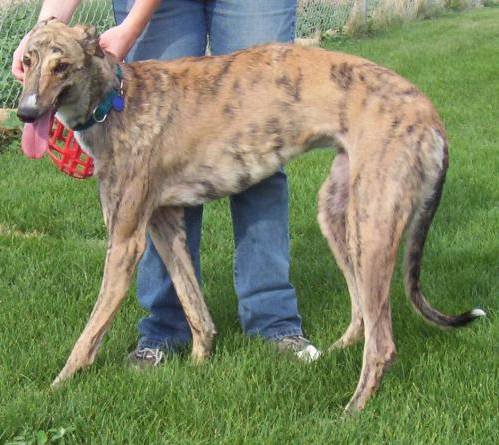

In [28]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + filenames[2])

In [29]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Validate Predictions


Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [30]:
vgg.model.load_weights(results_path+latest_weights_filename)

In [31]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [32]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [33]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 1958 correct labels


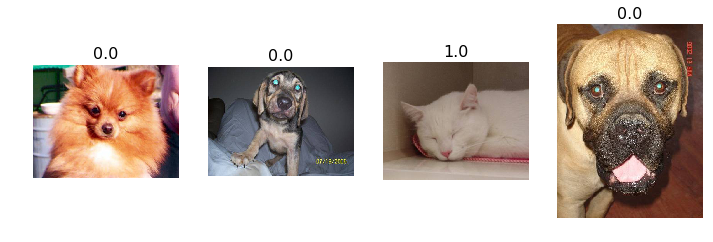

In [34]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 42 incorrect labels


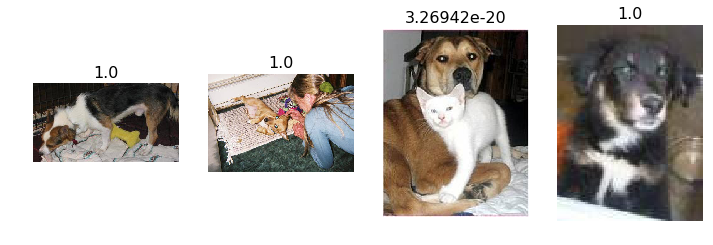

In [35]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 1005 confident correct cats labels


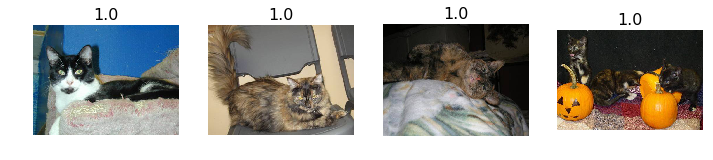

In [36]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 953 confident correct dogs labels


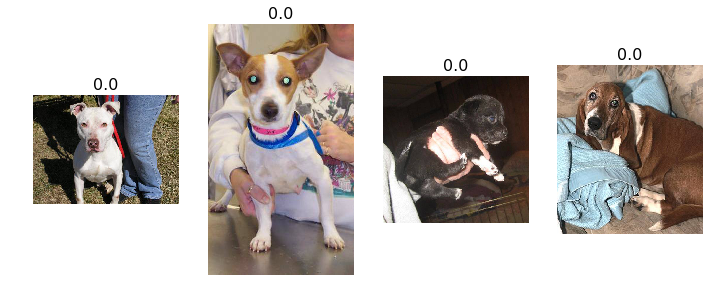

In [37]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 37 incorrect cats


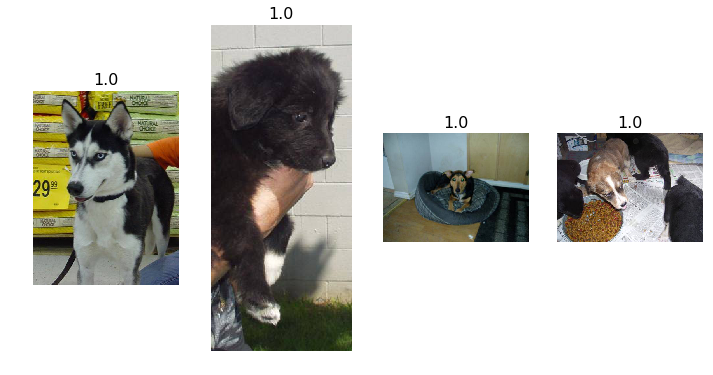

In [38]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 5 incorrect dogs


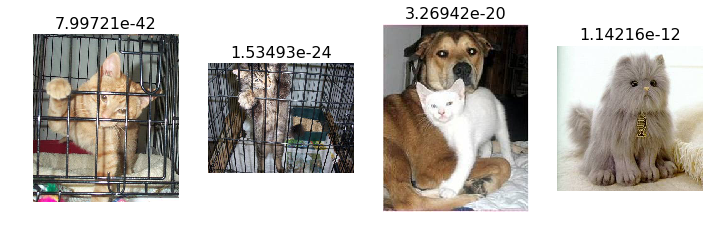

In [39]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

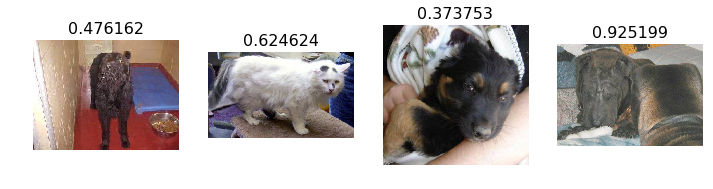

In [40]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[1005    5]
 [  37  953]]


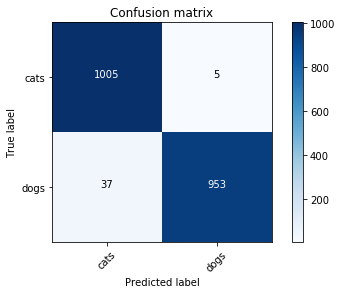

In [42]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Submit Predictions to Kaggle!


Here's the format Kaggle requires for new submissions:
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

Kaggle wants the imageId followed by the probability of the image being a dog. Kaggle uses a metric called [Log Loss](http://wiki.fast.ai/index.php/Log_Loss) to evaluate your submission.

In [43]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [44]:
#Grab the dog prediction column
isdog = preds[:,1]
print "Raw Predictions: " + str(isdog[:5])
print "Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)])
print "Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)])

Raw Predictions: [ 1.  1.  1.  0.  0.]
Mid Predictions: [ 0.5272  0.5163  0.4116  0.4642  0.5597]
Edge Predictions: [ 1.  1.  1. ...,  0.  0.  1.]


[Log Loss](http://wiki.fast.ai/index.php/Log_Loss) doesn't support probability values of 0 or 1--they are undefined (and we have many). Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values. This seems good, right?

Not so. There is an additional twist due to how log loss is calculated--log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). See visualization below.

In [46]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

ValueError: y_true contains only one label (1). Please provide the true labels explicitly through the labels argument.

In [47]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)

In [48]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [49]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  7.9090e+03,   9.5000e-01],
       [  9.6640e+03,   9.5000e-01],
       [  7.1790e+03,   9.5000e-01],
       [  1.2485e+04,   5.0000e-02],
       [  9.7900e+03,   5.0000e-02]])

In [50]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/courses/my_nbs/data/kaggle_dogs_cats


In [51]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR

/home/ubuntu/courses/my_nbs


In [52]:
FileLink('data/kaggle_dogs_cats/'+submission_file_name)

/home/ubuntu/courses/my_nbs/data/kaggle_dogs_cats/submission1.csv